In [1]:
import pandas as pd
from geopy.geocoders import OpenCage

In [2]:
df = pd.read_csv('ABIA_crosschecked.csv')

In [3]:
df['Address'] = df['PU-Name'] + ', ' + df['Ward'] + ', ' + df['LGA'] + ', ' + df['State']

In [4]:
print(df[['PU-Name', 'Address']].head())

                                       PU-Name  \
0        RAILWAY QUARTERS - RAILWAY QUARTERS I   
1       RAILWAY QUARTERS - RAILWAY QUARTERS II   
2      RAILWAY QUARTERS - RAILWAY QUARTERS III   
3                      ABIA POLY - ABIA POLY I   
4  LEVER BROTHERS GATE- LEVER BROTHERS GATE IV   

                                             Address  
0  RAILWAY QUARTERS - RAILWAY QUARTERS I, EZIAMA,...  
1  RAILWAY QUARTERS - RAILWAY QUARTERS II, EZIAMA...  
2  RAILWAY QUARTERS - RAILWAY QUARTERS III, EZIAM...  
3   ABIA POLY - ABIA POLY I, EZIAMA, ABA NORTH, ABIA  
4  LEVER BROTHERS GATE- LEVER BROTHERS GATE IV, I...  


In [5]:
geolocator = OpenCage('cfc767b54b1d4c279aa6907f86c37fd4')

In [6]:
def geocode_address(Address):
    try:
        location = geolocator.geocode(Address)
        return location.latitude, location.longitude
    except:
        return None, None

In [7]:
df[['latitude', 'longitude']] = df['Address'].apply(lambda x: pd.Series(geocode_address(x)))
df.to_csv('ABIA_crosschecked_geocod.csv', index=False)

In [9]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')

df[['latitude', 'longitude']] = imputer.fit_transform(df[['latitude', 'longitude']])

df.to_csv('ABIA_crosschecked_geocode.csv', index=False)


In [10]:
from geopy.distance import geodesic

def find_neighbors(df, radius=1.0):
    neighbors = {}
    for i, row in df.iterrows():
        neighbors[i] = []
        for j, other_row in df.iterrows():
            if i != j:
                distance = geodesic((row['latitude'], row['longitude']), (other_row['latitude'], other_row['longitude'])).km
                if distance <= radius:
                    neighbors[i].append(j)
    return neighbors

neighbors = find_neighbors(df, radius=1.0)


In [11]:
def calculate_outlier_scores(df, neighbors):
    outlier_scores = []
    parties = ['APC', 'LP', 'PDP', 'NNPP']
    for i, row in df.iterrows():
        scores = {}
        for party in parties:
            votes = row[party]
            neighbor_votes = df.loc[neighbors[i], party].mean() if neighbors[i] else 0
            scores[party + '_outlier_score'] = abs(votes - neighbor_votes)
        outlier_scores.append(scores)
    outlier_scores_df = pd.DataFrame(outlier_scores)
    return pd.concat([df, outlier_scores_df], axis=1)


df_with_scores = calculate_outlier_scores(df, neighbors)
df_with_scores.to_csv('ABIA_outlier_scores.csv', index=False)


In [14]:
parties = ['APC', 'LP', 'PDP', 'NNPP']
sorted_df = df_with_scores.sort_values(by=[party + '_outlier_score' for party in parties], ascending=False)
sorted_df.to_csv('ABIA_sorted_outliers.csv', index=False)


report = """
## Outlier Detection Report

### Methodology
We used geospatial analysis to identify neighboring polling units within a 1 km radius. We calculated an outlier score for each party by comparing the votes received by each polling unit to the average votes received by its neighbors. The absolute difference was used as the outlier score.

### Summary of Findings
The table below lists the polling units sorted by their outlier scores for each party.

### Top 3 Outliers
"""


for party in parties:
    top_outliers = sorted_df[['PU-Code', party, party + '_outlier_score']].head(3)
    report += f"\n#### {party}\n"
    report += top_outliers.to_markdown(index=False)


with open('outlier_detection_report.md', 'w') as f:
    f.write(report)


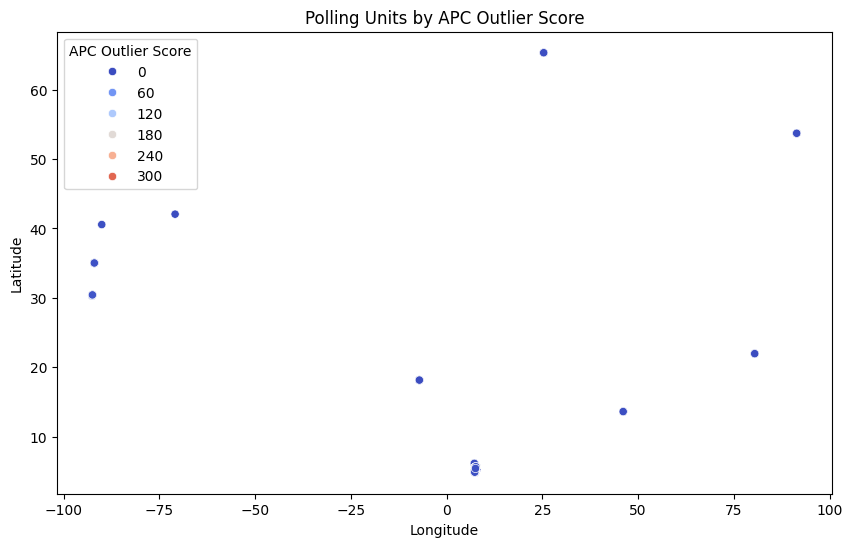

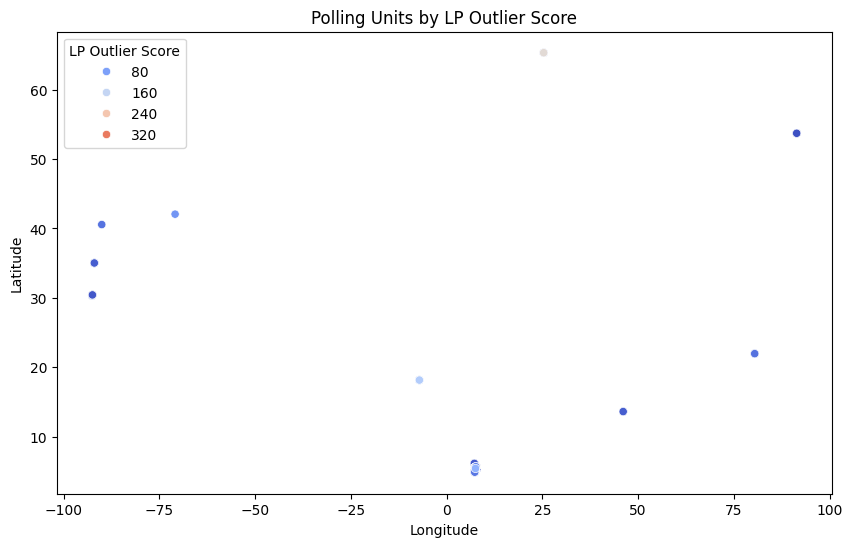

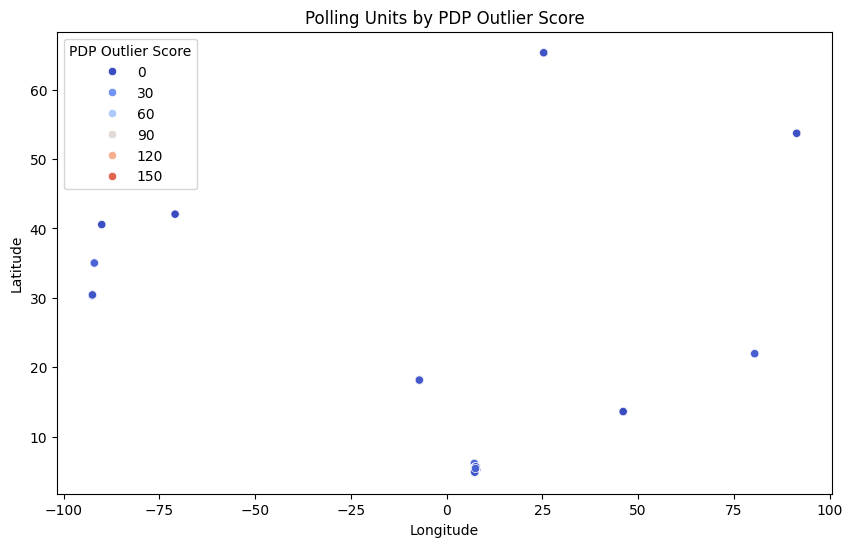

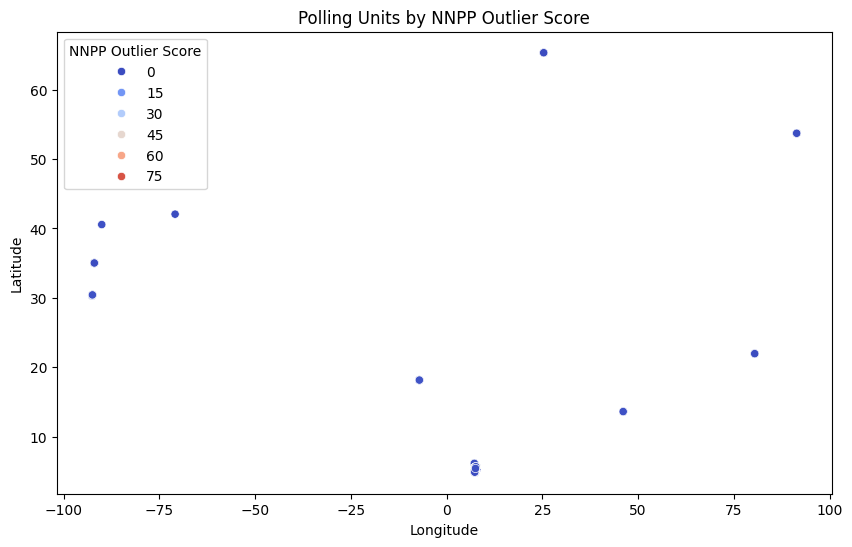

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

parties = ['APC', 'LP', 'PDP', 'NNPP']
for party in parties:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_with_scores, x='longitude', y='latitude', hue=party + '_outlier_score', palette='coolwarm')
    plt.title(f'Polling Units by {party} Outlier Score')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend(title=party + ' Outlier Score')
    plt.savefig(f'polling_units_{party}_outlier_score.png')
    plt.show()
